<a href="https://colab.research.google.com/github/Anvarjon/image_classification_using_tf/blob/master/Transfer_learning_img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.applications.resnet import ResNet101
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import glob
import os

IMG_H = 224
IMG_W = 224
NUM_CHAN = 3
lear_rate = 0.0001
main_dir = "/content/drive/My Drive/Colab Notebooks/"
tf_gpu = tf.test.is_gpu_available()
print("Tensorflow version ===> ", tf.__version__)
print("Tensorflow-gpu ===> ", tf_gpu)

Using TensorFlow backend.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Tensorflow version ===>  2.2.0
Tensorflow-gpu ===>  True


In [0]:
def plot_metrics(his):
    plt.rcParams['figure.figsize'] = (15, 4)
    x = range(len(his['acc']))
    x_tick = range(0, len(his['acc']), 5)
    plt.subplot(121)
    plt.title("Training and validation accuracy")
    plt.plot(x, his['acc'], label='Training accuracy')
    plt.plot(x, his['val_acc'], label='Validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.xticks(x_tick, x_tick)
    plt.grid(axis='y', linewidth=2)
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(122)
    plt.title("Training and validation loss")
    plt.plot(x, his['loss'], label='Training loss')
    plt.plot(x, his['val_loss'], label='Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.xticks(x_tick, x_tick)
    plt.grid(axis='y', linewidth=2)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
tr_path = pathlib.Path(main_dir + "data/images/train/")
val_path = pathlib.Path(main_dir + "data/images/valid/")

tr_img_count = len(list(glob.glob(main_dir + "data/images/train/*/*.bmp")))
val_img_count = len(list(glob.glob(main_dir + "data/images/valid/*/*.bmp")))

class_names = np.array([item.name for item in tr_path.glob("*")])
print("Training images   ===> ", tr_img_count)
print("Validation images   ===> ", val_img_count)
print("Class names ===> ", class_names)

Training images   ===>  335
Validation images   ===>  120
Class names ===>  ['abnormal' 'normal']


In [22]:
BATCH_SIZE = 10

TR_STEP_PER_EPOCH = np.ceil(tr_img_count/BATCH_SIZE)
VAL_STEP_PER_EPOCH = np.ceil(val_img_count/BATCH_SIZE)

img_gen = image.ImageDataGenerator(rescale=1./255)
tr_data_gen = img_gen.flow_from_directory(directory=str(tr_path),
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           color_mode='rgb',
                                           target_size=(IMG_H, IMG_W),
                                           classes=list(class_names))

val_data_gen = img_gen.flow_from_directory(directory=str(val_path),
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           color_mode='rgb',
                                           target_size=(IMG_H, IMG_W),
                                           classes=list(class_names))

Found 335 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [0]:
base_model = ResNet101(weights='imagenet',
                                include_top=False,
                                input_shape=(IMG_H, IMG_W, NUM_CHAN))

In [0]:
base_model.trainable=False

In [0]:
# for layer in base_model.layers[:-1]:
#     layer.trainable = False

In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.3)(x)
# x = Dense(1024, activation='relu')(x)
# x = keras.layers.Dropout(0.2)(x)
# x = Dense(256, activation='relu')(x)
# x = keras.layers.Dropout(0.2)(x)
out = Dense(1)(x)
model = Model(inputs=base_model.input, outputs=out)

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lear_rate), 
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
metrics=['acc'])
# print(model.summary())

In [23]:
EPOCHS = 40
c_weights = {0:4, 1:1}
Bm_clb = ModelCheckpoint(main_dir + "best_resnet101.h5", monitor="val_acc", save_best_only=True)

hist = model.fit_generator(tr_data_gen, 
                               steps_per_epoch=TR_STEP_PER_EPOCH,
                               epochs=EPOCHS,
                               callbacks=[Bm_clb],
                               validation_data=val_data_gen,
                               validation_steps=VAL_STEP_PER_EPOCH,                               
                               class_weight=c_weights)

Epoch 1/40
34/34 [==============================] - 400s 12s/step - loss: 2.4789 - acc: 0.3209 - val_loss: 0.8703 - val_acc: 0.0000e+00


OSError: ignored

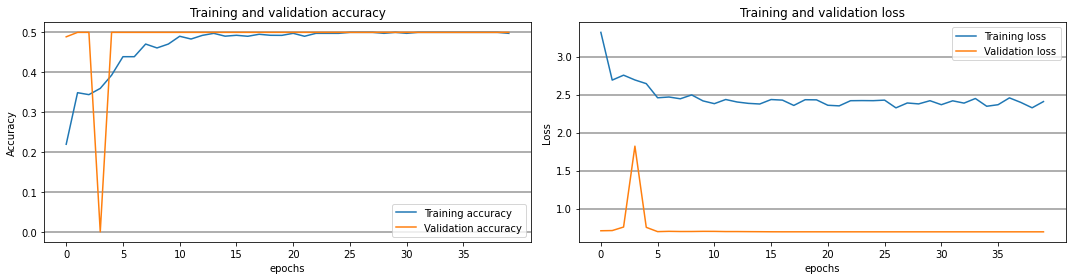

In [0]:
plot_metrics(hist.history)

In [0]:
pred = model.predict_generator(val_data_gen, steps=VAL_STEP_PER_EPOCH)
val_lab = val_data_gen.classes
print("Validation labels shape     ===> ", val_lab.shape)
print("Validation prediction shape ===> ", pred.shape)

(90, 1)

In [0]:
report = classification_report(val_lab, pred)
cm = confusion_matrix(val_lab, pred)

print(30*"*", " Classification report ", 30*"*")
print(30*"=", " Resnet_101 ", 30*"=")
print(report)
print(30*"*", " Confusion matrix ", 30*"*")
print(cm)

******************************  Classification report  ******************************
==============================  Resnet_101  ==============================
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        80
           1       0.00      0.00      0.00        10

    accuracy                           0.89        90
   macro avg       0.44      0.50      0.47        90
weighted avg       0.79      0.89      0.84        90

******************************  Confusion matrix  ******************************
[[80  0]
 [10  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn